# Chapter 3. エコーステートネットワーク基礎

この章では、リザバー計算 (Reservoir Computing; RC)の文脈で頻繁に使用されるエコーステートネットワーク (Echo State Network; ESN)の基礎と標準的な設定を学びます。

## 前書き

ESNは、H. Jaeger<sup>[1]</sup>(2001) によって提案されたリカレントニューラルネットワーク (Recurrent Neural Network; RNN)の一種です。
RNNは深層学習で一般的に用いられるフィードフォワードネットワークとは異なり、その再帰結合によって特徴づけられます。
またRCでは一般的なRNN (Long-Short-Term Memory; LSTMやGated Recurrent Unit; GRU等)とは異なり、その再帰結合は固定化されたまま、リードアウト層 (readout layer)と呼ばれる外部のパラメータのみが調整されます。
このような設定で使用されるRNNはリザバー (reservoir)と呼ばれ、RCでは最も単純なセットアップとしてESNがリザバーとして用いられます。

RCはリザバーを用いて様々な時系列タスクを解くフレームワークで、教師あり時系列学習に分類されます。
通常時系列は、毎ステップ入力としてリザバーの内部状態に与えられ、再帰結合と非線形関数に従ってその内部状態が時間発展します。
またRCでは先述のとおり、再帰結合の調整を伴わず、外部のリードアウト層のみの学習だけで多様な非線形な入出力処理を実現します。
ここで重要なポイントとして、リザバーの内部状態の高次元性と非線形性が挙げられます。
一般にリザバーは高次元であるほど高い情報処理能力を有しますが、それは履歴として入力の情報を蓄積できるだけの(記憶)容量を、高次元な設定では確保しやすいからです。
また非線形関数をその活性化関数として有すると、非線形変換が施された多様な入力の情報を保持します。
他にもESNを用いたRCについて一般に以下の特長が挙げられます。
- 非線形な活性化関数を使用 (この点はRNNと同様)
- 通常再帰結合のパラメータをランダムに設定し**固定して**使用
- **外側のリードアウト層のみを学習**するため誤差逆伝搬法等と比して低計算コスト
- 同じリザバーを再利用しながら複数のリードアウト層により**マルチタスキング** (Multitasking; 文脈によってはMultiplexingとも呼ばれる)が容易に可能

<div style="text-align: center; width: 750px; margin: auto; background-color: #f8f9fa; padding: 10px; border-radius: 10px;">

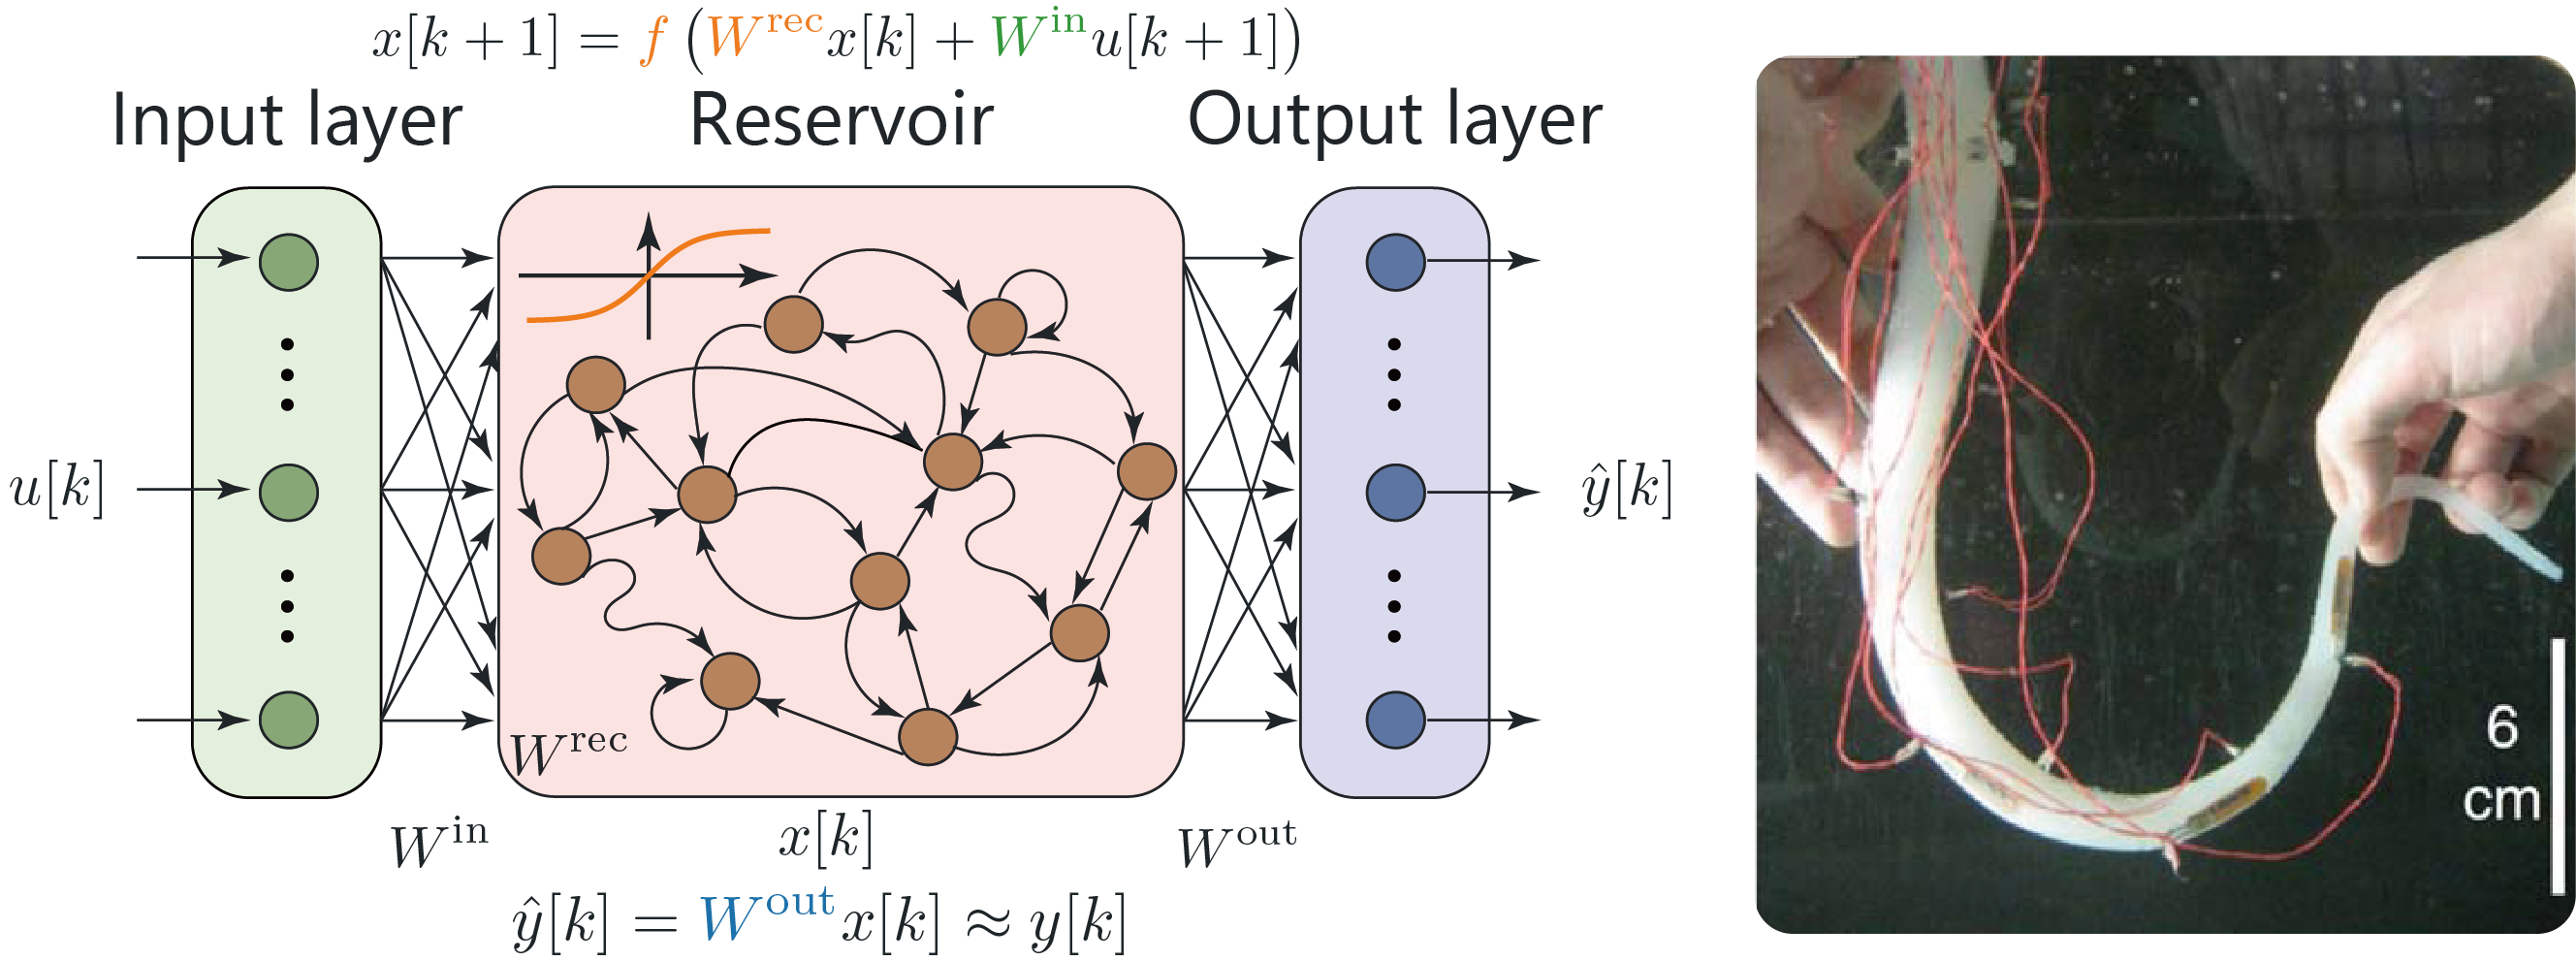
</div>

<figcaption align = "center">

図1 (左)ESNの基本的構成。 (右) タコの腕を模したシリコンベースのソフトアームによる物理リザバー計算<sup>[3]</sup>。

</figcaption>

内部結合の調整を伴わないランダムニューラルネットワークを使用するため、原理的には非線形性を有する大自由度のシステム (大自由度非線形力学系)であれば、リザバーの物理的実装の候補となります。
これらの実装は、実際に物理リザバー計算 (Physical Reservoir Computing; PRC)の分野で盛んに研究されています<sup>[3]</sup>。
例えば水中のタコの足の動きをセンシングし、その時系列データを計算資源として活用して、パリティービットチェックタスク等の非線形処理を実現できます。

### ESNの定式化

ここまで説明されたように、RCは入出力関係を学習する手法で、機械学習の一種である教師あり学習に分類されます。
学習の要点をまとめると下記のとおりになります。

0. 時系列入出力データの用意
1. 適切なESNモデルの選択ならびにハイパーパラメータの調整
2. 初期値の影響がなくなるまで系を時間発展 (ウォッシュアウト; washout)
3. 学習アルゴリズムの選択およびリードアウト層の調整
4. 入力データに対する出力データのサンプリング
5. 訓練誤差ならびに汎化誤差の評価

以下ESNの定式化のため、下記の表記を導入しながらより詳細を説明します。
なおわかりやすさのため以降、離散時間上で定義される時系列や関数には角括弧 $[\cdot]$、連続時間上で定義される時系列には丸括弧$(\cdot)$を用います。
教科書や論文等によっては丸括弧$(\cdot)$ や添字表記を用いる場合もありますが、意味は同じです。

- $k\in\mathbb{Z}$: 離散時間
- $u[k] \in \mathbb{R} $: 1次元入力
- $x[k] \in \mathbb{R}^{N}$: リザバーの内部状態
- $g: \mathbb{R}^{N}\to \mathbb{R}$: リードアウト層の関数
- $y[k] \in \mathbb{R} $: 入力時系列$\{u[0], u[1],~\ldots,~u[k]\}$ によって生成される目標出力

RCでは$\hat{y}[k]=g(x[k])\approx y[k]$ によって目標出力$y[k]$ の近似を目指します。
また、後の章でも改めて取り上げますが、$u[k]$ に対する**エコーステート性 (Echo State Property; ESP)** は、そのリザバーの情報処理能力を十分活用する上で重要な性質で、次の式を満たす系の性質を指します。

$$
\begin{align*}
x[k] = \varphi(u[k], u[k-1],~\ldots)
.\end{align*}
$$

換言すれば、ESPを満たす系は十分時間が経てばその内部状態の初期値に関わらず入力時系列$u[k]$によって内部状態がある関数$\varphi$で定まる値に収束します (漸近的に初期値$x[0]$の情報を消失)。
またこの$\varphi$は **エコー関数 (echo function)** と呼ばれます。

ここでESPはリザバーの要件として重要で、わかりやすさのためまず先に取り上げますが、必ずしも全てのRCにおいて必須ではない点に注意してください。
例えば後の章では初期値鋭敏性を有するカオス系を活用するRCについて学びますが、カオス系ではESPは満たされません。
また近年ではESPの拡張としてエコーインデックス (Echo Index; EI)が提案されており、全体としてESPは満たさないが、局所的に安定な応答を複数もつ系の場合にも対応しています<sup>[4]</sup>。
このようにESPを含めリザバーの要件に関する研究は現在も継続的に進められています。

#### 入力層

- $W^\mathrm{in} \in \mathbb{R}^{N}$: 入力層の結合

$W^\mathrm{in}$は通常固定化され、しばしば一様分布$\mathcal{U}([-\sigma, \sigma])$を用いてランダムに生成されます。
またこの際使用される$\sigma\in \mathbb{R}$はしばしば入力スケールと呼ばれます。

#### リザバー層

- $x[k] \in \mathbb{R}^{N}$: 時刻$t$における内部状態
- $W^\mathrm{rec} \in \mathbb{R}^{N\times N}$: 内部結合

$W^\mathrm{rec}$は多くの場合**スペクトル半径** $\rho(W^\mathrm{rec})$ によって制御されます。
これは$W^\mathrm{rec}$ の固有値の絶対値の最大値です (固有値が複素数を取りうる点に注意してください)。
このスペクトル半径の大小により入力に対する記憶特性が著しく変化します。

#### リードアウト層 (1タスク)

- $\hat{y}[k] \in \mathbb{R}$: 出力時系列
- $W^\mathrm{out} \in \mathbb{R}^{N + 1}$: 出力層の結合パラメータ

$W^\mathrm{out}$は学習データによって調整されます。
なお$N$ではなく$N+1$次元となっているのは、後述しますが定数項 (バイアス)に相当する項が増えているためです。

#### ESNの時間発展と出力

内部状態$x[k]$と出力$\hat{y}[k]$の時間発展は以下の式で表されます。

$$
\begin{align*}
x[k+1] &= f(W^\mathrm{rec}x[k] + W^\mathrm{in} u[k+1]) \\
\hat{y}[k] &= {W^\mathrm{out}}^\top [1 ; x[k]] \\
&= {W^\mathrm{out}}^\top {[1 \quad x_1[k] \quad \cdots \quad x_{N}[k]]}^\top \\
&= W^\mathrm{out}_0 + \sum_{i=1}^{N} W^\mathrm{out}_i x_{i}[k]
,\end{align*}
$$

ここで$f:\mathbb{R}^N\to \mathbb{R}^N$は活性化関数と呼ばれ、ESNではよく$\tanh$が使用されます ($f(x)=[\tanh(x_1[k]) \quad \cdots \quad \tanh(x_N[k]) ]^\top$)。

#### その他の形式

フィードバックループを明示的に導入できます。
これは閉ループ制御の文脈で登場します。

$$
\begin{align*}
x[k+1] = f(W^\mathrm{rec}x[k] + W^\mathrm{in}u[k + 1] + W^\mathrm{fb}\hat{{y}}[k])
.\end{align*}
$$

漏れ率 (leaky rate)を導入してより内部状態を保持しやすくしたリーキーESN (leaky ESN) も存在します。

$$
\begin{align*}
x[k+1] = (1-a)~x[k] + a~{f}(W^\mathrm{rec}x[k] + W^\mathrm{in}u[k+1])
.\end{align*}
$$

## 演習問題と実演

ここからは演習問題とデモンストレーションに移ります。
(離散) ESNを構築し、NARMA10と呼ばれる典型的なベンチマークタスクに取り組みましょう。
前章同様、まず次のセルを実行してください。

In [ ]:
import math
import sys

import numpy as np

if "google.colab" in sys.modules:
    from google.colab import drive  # type: ignore

    if False:  # Set to True if you want to use Google Drive and save your work there.
        drive.mount("/content/gdrive")
        %cd /content/gdrive/My Drive/rc-bootcamp/
        # NOTE: Change it to your own path if you put the zip file elsewhere.
        # e.g., %cd /content/gdrive/My Drive/[PATH_TO_EXTRACT]/rc-bootcamp/
    else:
        pass
        %cd /content/
        !git clone --branch ja_sol https://github.com/rc-bootcamp/rc-bootcamp.git
        %cd /content/rc-bootcamp/
else:
    sys.path.append(".")

from utils.style_config import plt
from utils.tester import load_from_chapter_name
from utils.viewer import show_3d_coord

test_func, show_solution = load_from_chapter_name("03_esn_basics")

### 1. 入力層・ESNの実装

まず初めに入力層に相当する`Linear`クラスと、リザバー層におけるESNを実装する`ESN`クラスを作成しましょう。

Q1.1.

以下の穴埋めを実装し、結合行列$W\in \mathbb{R}^{N_\mathrm{out}\times N_\mathrm{in}}$とバイアス項$b\in\mathbb{R}^{N_\mathrm{out}}$を保持し、入力$u[k]\in\mathbb{R}^{... \times N_\mathrm{in}}$を線形変換して得られた多次元ベクトル$W u[k] + b \in \mathbb{R}^{... \times N_\mathrm{out}}$を出力するクラス`Linear`を完成させよ。
ただし$W$と$b$の要素はそれぞれ$\mathcal{U}([-\sigma_W, \sigma_W])$と$\mathcal{U}([-\sigma_b, \sigma_b])$ (引数中の`bound`と`bias`)で初期化される。

- `Linear.__call__`
  - Argument(s):
    - `x`: `np.ndarray`
      - `shape`: `(..., input_dim)`
  - Return(s):
    - `out`: `np.ndarray`
      - `shape`: `(..., output_dim)`

<details><summary>tips</summary>

- [`np.swapaxes`](https://numpy.org/doc/stable/reference/generated/numpy.swapaxes.html)
- [`np.matmul`](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html)

</details>

In [ ]:
class Module(object):
    def __init__(self, *_args, seed=None, rnd=None, dtype=np.float64, **_kwargs):
        if rnd is None:
            self.rnd = np.random.default_rng(seed)
        else:
            self.rnd = rnd
        self.dtype = dtype


class Linear(Module):
    def __init__(self, input_dim: int, output_dim: int, bound: float = None, bias: float = 0.0, **kwargs):
        """
        Linear model

        Args:
            input_dim (int): input dimension
            output_dim (int): output dimension
            bound (float, optional): sampling scale for weight. Defaults to None.
            bias (float, optional): sampling scale for bias. Defaults to 0.0.
        """
        super(Linear, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.output_dim = output_dim
        if bound is None:
            bound = math.sqrt(1 / input_dim)
        self.weight = self.rnd.uniform(-bound, bound, (output_dim, input_dim)).astype(self.dtype)
        self.bias = self.rnd.uniform(-bias, bias, (output_dim,)).astype(self.dtype)

    def __call__(self, x: np.ndarray):
        x = np.asarray(x)
        out = np.matmul(x, self.weight.swapaxes(-1, -2)) + self.bias  # TODO Use `swapaxes` and `matmul`.
        return out


def solution(input_dim, output_dim, seed, bound, bias, mat):
    # DO NOT CHANGE HERE.
    lin = Linear(input_dim, output_dim, bound=bound, bias=bias, seed=seed)
    return lin(mat)


test_func(solution, "01_01")
# show_solution("01_01", "Linear")  # Uncomment it to see the solution.

Q1.2.

次に以下の穴埋めを実装し、ESNの内部状態とその時間発展を制御する`ESN`クラスを完成させよ。
ただし、`ESN`はスペクトル半径が1になるように正規化された$W^\mathrm{rec}\in\mathbb{R}^{N\times N}~(\text{s.t.}~\rho(W^\mathrm{rec})=1)$と非線形パラメータ$\rho \in \mathbb{R}$を保持し、入力$v[k+1]$と内部状態$x[k]$に対する時間発展は以下の式で表される。

$$
\begin{align*}
x[k+1] = f(\rho W^\mathrm{rec} x[k] + v[k+1])
.\end{align*}
$$

- `ESN.__call__`
  - Argument(s):
    - `x`: `np.ndarray`
      - `shape`: `(..., dim)`
    - `v`: `np.ndarray`
      - `shape`: `(..., dim)`
  - Return(s):
    - `x_next`: `np.ndarray`:
      - `shape`: `(..., dim)`

<details><summary>tips</summary>

- [`scipy.sparse.linalg.eigs`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigs.html)を使用せよ。
  - 再現性のため、`v0=np.ones((dim,))`を指定せよ。
  - 高速化のため、`which='LM', k=1`を指定せよ。
- [Spectral radius](https://en.wikipedia.org/wiki/Spectral_radius)

</details>

In [ ]:
from scipy.sparse.linalg import ArpackNoConvergence, eigs


class ESN(Module):
    def __init__(
        self,
        dim: int,
        sr: float = 1.0,
        f=np.tanh,
        a: float | None = None,
        p: float = 1.0,
        init_state: np.ndarray | None = None,
        normalize: bool = True,
        **kwargs,
    ):
        """
        Echo state network [Jaeger, H. (2001). Bonn, Germany:
        German National Research Center for Information Technology GMD Technical Report, 148(34), 13.]

        Args:
            dim (int): number of the ESN nodes
            sr (float, optional): spectral radius. Defaults to 1.0.
            f (callable, optional): activation function. Defaults to np.tanh.
            a (float | None, optional): leaky rate. Defaults to None.
            p (float, optional): density of connection matrix. Defaults to 1.0.
            init_state (np.ndarray | None, optional): initial states. Defaults to None.
            normalize (bool, optional): decide if normalizing connection matrix. Defaults to True.
        """
        super(ESN, self).__init__(**kwargs)
        self.dim = dim
        self.sr = sr
        self.f = f
        self.a = a
        self.p = p
        if init_state is None:
            self.x_init = np.zeros(dim, dtype=self.dtype)
        else:
            self.x_init = np.array(init_state, dtype=self.dtype)
        self.x = np.array(self.x_init)
        # Generating normalized sparse matrix
        while True:
            try:
                self.weight = self.rnd.normal(size=(self.dim, self.dim)).astype(self.dtype)
                if self.p < 1.0:  # Sparse matrix
                    # TODO (Optional!) Implement sparse matrix with density `self.p`.
                    w_con = np.full((dim * dim,), False)
                    w_con[: int(dim * dim * self.p)] = True
                    w_con = w_con.reshape((dim, dim))
                    self.rnd.shuffle(w_con)
                    self.weight = self.weight * w_con
                    # end of TODO
                if normalize:
                    # TODO Calculate `spectral_radius`. Use `eigs` and specify `v0` parameter as `np.ones(self.dim)` to ensure the reproducibility.
                    eigen_values = eigs(self.weight, return_eigenvectors=False, k=1, which="LM", v0=np.ones(self.dim))
                    spectral_radius = max(abs(eigen_values))
                    # end of TODO
                    self.weight = self.weight / spectral_radius  # TODO Normalize the weight matrix.
                break
            except ArpackNoConvergence:
                continue

    def __call__(self, x: np.ndarray, v: np.ndarray | None = None):
        x_next = self.sr * np.matmul(x, self.weight.swapaxes(-1, -2))  # TODO Calculate the next state `x_next`.
        if v is not None:
            x_next += v  # TODO Add the input `v` if it is given.
        x_next = self.f(x_next)  # TODO Apply the activation function.
        if self.a is None:
            return x_next
        else:
            return (1 - self.a) * x + self.a * x_next

    def step(self, v: np.ndarray | None = None):
        self.x = self(self.x, v)


def solution(dim, sr, seed, xmat, vmat):
    # DO NOT CHANGE HERE.
    net = ESN(dim, sr=sr, f=np.tanh, seed=seed)
    return net(xmat, v=vmat)


test_func(solution, "01_02")
# show_solution("01_02", "ESN")  # Uncomment it to see the solution.

次のコードにより`ESN.w_net`のスペクトル半径が1以下すなわち、固有値が単位円内に収まっているかどうか確認しましょう。

<details><summary>tips</summary>

- [円則](https://ja.wikipedia.org/wiki/%E3%83%A9%E3%83%B3%E3%83%80%E3%83%A0%E8%A1%8C%E5%88%97#%E5%86%86%E5%89%87)

</details>

In [ ]:
def show_eigen(mat):
    assert mat.ndim == 2
    assert mat.shape[0] == mat.shape[1]
    ts = np.linspace(0, 2 * np.pi, 100001)
    es = np.linalg.eigvals(mat)
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(np.real(es), np.imag(es), s=3.0)
    ax.plot(np.cos(ts), np.sin(ts), lw=1.0, ls=":", color="k")
    ax.set_xlabel("real")
    ax.set_ylabel("imag")


net = ESN(500, sr=1.0, seed=1234)
show_eigen(net.weight)

Q1.3. (Advanced)

- 上記のコードで密度$p$ (`math.floor(self.dim * self.dim * p)`個の要素だけ非零) のスパース行列を作成するコードが穴埋めになっている。同様に自力での実装を試みよ。
- `normalize=False`を指定し、固有値の分布がどうなるか確認せよ。またスパース ($p < 1$)なケースでの変化も確認せよ。
- ノード数が非常に大きい時 (e.g., $N > 10^4$)、固有値の計算は非常に時間がかかるため、`normalize=True`の指定は現実的でない。この際、ノード数$N$と結合密度$p$から、おおよそのスペクトル半径が$1$になる定数倍の係数を求めよ。
ただし検証は`normalize=False`を用いて行え。

### 2. ウォッシュアウト

**ウォッシュアウト** (内部状態の「洗い流し」)は、初期条件の影響を消失させるために導入されます。
ウォッシュアウトにより、システムが同じ入力に対して同じ内部状態を再現的に取るようになり結果的に計算能力の向上が見込めます。

- $T_\mathrm{washout}$: ウォッシュアウトの時間ステップ
- $T_\mathrm{sample}$: その後サンプリングする時間ステップ
- $U=\{u[-T_\mathrm{washout}],~\ldots,~u[0],~\ldots,~u[T_\mathrm{sample} - 1] \}$: 入力時系列

先程実装した`ESN`と`Linear`を用いてウォッシュアウトの効果を確かめてみましょう。
以下のコードは一様乱数$\mathcal{U}([-1, 1])$からサンプルされた同じ入力$u[k]$に対する`sample_num`個の異なる初期値のESNの応答を表示するコードです。

In [ ]:
rnd = np.random.default_rng(1234)

dim_in = 1
dim_esn = 100  # The number of ESN nodes
sample_num = 3  # The number of randomly-sampled initial conditions
t_washout, t_sample = 100, 1000
t_total = t_washout + t_sample

ts = np.arange(-t_washout, t_sample)
us = rnd.uniform(-1, 1, (t_total, dim_in))  # Input sequence
x_init = rnd.uniform(-1, 1, (sample_num, dim_esn))  # Initial conditions

w_in = Linear(dim_in, dim_esn, bound=0.1, bias=0.0, rnd=rnd)
net = ESN(dim_esn, sr=0.995, f=np.tanh, rnd=rnd, init_state=x_init)

x = x_init
xs = np.zeros((t_total, *x_init.shape))  # Shape: (t_total, sample_num, dim_esn)
for idx, _t in enumerate(ts):
    x = net(x, w_in(us[idx]))
    xs[idx] = x

`xs`を下のコードで表示してみましょう。

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

ax[0, 0].plot(ts[:t_washout], xs[:t_washout, :, 0])
ax[1, 0].plot(ts[:t_washout], xs[:t_washout, :].mean(axis=-1))
ax[0, 1].plot(ts[-100:], xs[-100:, :, 0])
ax[1, 1].plot(ts[-100:], xs[-100:, :].mean(axis=-1))
ax[0, 0].set_ylabel(r"$x_0[k]$")
ax[1, 0].set_ylabel(r"$\bar{x}[k]$")
ax[0, 0].set_title(r"$k\in[-T_\mathrm{washout}, 0)$")
ax[0, 1].set_title(r"$k\in[T_\mathrm{sample} - 100, T_\mathrm{sample})$")

None

以下のコードは、最初の3ノード$x_0, x_1, x_2$で3次元座標を構築し、その軌跡を表示します。
まずは$k\in[-T_\mathrm{washout}, 0)$の区間のみ表示します。

In [ ]:
fig = show_3d_coord(
    xs[:t_washout, 0, :3],
    xs[:t_washout, 1, :3],
    xs[:t_washout, 2, :3],
    axes=["x_{}[k]".format(idx) for idx in range(3)],
)
fig.show()

$k\in[T_\mathrm{sample} - 100, T_\mathrm{sample})$の区間は以下のとおりです。
ほとんど重なっている様子が見えます。

In [ ]:
fig = show_3d_coord(
    xs[-100:, 0, :3],
    xs[-100:, 1, :3],
    xs[-100:, 2, :3],
    axes=["x_{}[k]".format(idx) for idx in range(3)],
)
fig.show()

Q2.1. (Advanced)

他のパラメータを変えて同様にウォッシュアウトの効果を確認しESPに対する理解を深めよう。
- `sr`を変えよ。特に1以上のケースを確認せよ。
- `bound`を変えてみよ。
- `esn_dim`を大きくさせてみよ。
- 異なる活性化関数`f`を試せ。

### 3. 学習: 線形回帰によるリードアウト層の学習

学習は線形回帰によりワンショット方式で達成されます。
このような学習方式は**オフライン学習** (offline training)と呼ばれます。

- $T_\mathrm{train}$: 学習の時間ステップ
- $\{u[0],~\ldots,~u[T_\mathrm{train} - 1]\}$: 入力時系列
- $\{y[0],~\ldots,~y[T_\mathrm{train}- 1]\}$: 目標時系列

タスク$y[k]$のコスト関数$\mathrm{RSS}$ は次のように定義されます。

$$
\mathrm{RSS} := \sum_{k=0}^{T_\mathrm{train}-1} \|  y[k] - \hat{y}[k] \|^2,
$$

さらに以下のように展開されます。

$$
\begin{align*}
\mathrm{RSS} &= \sum_{k=0}^{T_\mathrm{train}-1} \| y[k] - \hat{y}[k] \|^2 \\
&=  \sum_{k=0}^{T_\mathrm{train}-1} \| y[k] - [1: x[k]]w^\mathrm{out} \|^2 \\
&= \| y^\mathrm{train} - X^\mathrm{train}w^\mathrm{out} \|^2
,\end{align*}
$$

ただし

$$
\begin{align*}
X^\mathrm{train} &:= \begin{bmatrix}
1 & x_{0}[0] &\cdots & x_{N-1}[0] \\
\vdots & \vdots & \ddots & \vdots \\
1 & x_{0}[T_\mathrm{train}-1] & \cdots & x_{N-1}[T_\mathrm{train}-1]
\end{bmatrix} \in \mathbb{R}^{T_\mathrm{train} \times (N + 1)} \\
y^\mathrm{train} &:= [y[0] \quad \cdots \quad y[T_\mathrm{train}-1]]^\top \in \mathbb{R}^{T_\mathrm{train}} \\
w^\mathrm{out} &:= [{w}^\mathrm{out}_{0} \quad {w}^\mathrm{out}_{1} \quad \cdots \quad {w}^\mathrm{out}_{N} ]^\top \in \mathbb{R}^{N+1}
.\end{align*}
$$

${X^\mathrm{train}}^\top X^\mathrm{train}$ の階数が最大 (full-rank) の場合、$\mathrm{RSS}$ を最小化する最適解は次の式で得られます。

$$
\hat{w}^\mathrm{out} = \arg \min_{w^\mathrm{out}}\mathrm{RSS} = ({X^\mathrm{train}}^\top X^\mathrm{train})^{-1}{X^\mathrm{train}}^\top y^\mathrm{train},
$$

最後に、評価フェーズの出力 ($t \in [T_\mathrm{train}, T_\mathrm{train}+T_\mathrm{eval}-1] $) は次のように記述されます。

$$
\begin{align*}
\hat{y}[k] &= [1:x[k]]\hat{w}^\mathrm{out} \\
\hat{y} &= X^\mathrm{eval}\hat{w}^\mathrm{out}
,\end{align*}
$$

ただし

$$
X^\mathrm{eval} =
\begin{bmatrix} 1 & x_{0}[T_\mathrm{train}] &\cdots & x_{N-1}[T_\mathrm{train}] \\
 \vdots & \vdots & \ddots & \vdots \\
  1 & x_{0}[T_\mathrm{train}+T_\mathrm{eval}-1] & \cdots & x_{N-1}[T_\mathrm{train}+T_\mathrm{eval}-1]
\end{bmatrix} \in \mathbb{R}^{T_\mathrm{eval} \times (N + 1)}.
$$

Q3.1.

先程実装した`Linear`を継承し、与えられた$X \in \mathbb{R}^{T\times N^\mathrm{in}}, Y \in \mathbb{R}^{T \times N^\mathrm{out}}$に対して上記の線形回帰を実行し、得られた$\hat{w}^\mathrm{out}$を用いて、重みとバイアスを更新する`LRReadout`を実装せよ。

- `LRReadout.train`
  - Argument(s):
    - `x`: `np.ndarray`
      - `shape`: `(time_steps, input_dim)`
    - `y`: `np.ndarray`
      - `shape`: `(time_steps, output_dim)`
  - Return(s):
    - `self.weight`: `np.ndarray`
      - `shape`: `(output_dim, input_dim)`
    - `self.bias`: `np.ndarray`
      - `shape`: `(output_dim,)`

  - Operation(s):
      - `self.weight`の更新
      - `self.bias`の更新

<details><summary>tips</summary>

- [`np.linalg.lstsq`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html)

</details>

In [ ]:
class LRReadout(Linear):
    def train(self, x: np.ndarray, y: np.ndarray):
        assert (x.ndim == 2) and (x.shape[-1] == self.input_dim)
        assert (y.ndim == 2) and (y.shape[-1] == self.output_dim)
        # TODO Use `lstsq` to calculate the optimal weight and bias.
        x_biased = np.ones((x.shape[0], x.shape[1] + 1), dtype=self.dtype)
        x_biased[:, 1:] = x
        sol, _residuals, _rank, _s = np.linalg.lstsq(x_biased, y, rcond=None)
        self.weight[:] = sol[1:].T
        self.bias[:] = sol[0]
        # end of TODO
        return self.weight, self.bias


def solution(dim_in, dim_out, x_train, y_train, x_eval):
    # DO NOT CHANGE HERE.
    readout = LRReadout(dim_in, dim_out)
    readout.train(x_train, y_train)
    return readout(x_eval)


test_func(solution, "03_01")
# show_solution("03_01", "LRReadout")  # Uncomment it to see the solution.

### 4. NARMA10―10次の非線形自己回帰移動平均<sup>[5]</sup>

NARMA (Nonlinear AutoRegressive Moving Average) 10<sup>[5]</sup> は、RC で頻繁に使用される典型的なベンチマークです。
自己回帰部分と移動平均部分で構成される非線形 ARMA (AutoRressive Moving Average)モデルであり、現在と過去値の間には非線形な関係があります。
典型的には一様ランダム入力 $u[k]\sim\mathcal{U}([-1,1])$に対して、NARMA10 モデルは次のように定義されます。

$$
\begin{align*}
y[k+1] &= \alpha y[k] + \beta y[k]\sum_{i=0}^{9}y[k-i] + \gamma \nu[k-9]\nu[k] + \delta \\
\nu[k]&=\mu u[k]+\kappa
,\end{align*}
$$

ここで、$(\alpha,\beta,\gamma,\delta,\mu,\kappa)=(0.3,0.05,1.5,0.1,0.25,0.25)$がよく用いられます。
値の発散を避けるために、入力 $u[k]$ は慎重に調整されます。
特に$(\mu,\kappa)=(0.25,0.25)$により$\nu[k] \sim \mathcal{U}([0.0, 0.5])$ にスケーリングされる場合が多いです。

Q4.1.

長さ$T + 10$の入力時系列 $U=\{u[-10],~\ldots,~u[T-1]\}\in\mathbb{R}^{(T+10)\times d}$、
長さ10の時系列 $Y^\mathrm{init}=\{y[-10],~\ldots,~y[-1]\}\in \mathbb{R}^{10 \times d}$
が与えられる。
NARMA10
上記の式に従い変換を施したNARMA10の時系列 $Y=\{y[-10],~\ldots,~y[0],~\ldots,~y[T-1]\}\in\mathbb{R}^{T\times d}$ を出力する関数`narma_func`を実装せよ。

- `narma_func`
  - Argument(s):
    - `us`: `np.ndarray`
      - `shape`: `(t + 10, d)`
    - `y_init`: `np.ndarray`
      - `shape`: `(10, d)`
  - Return(s):
    - `ys`: `np.ndarray`
      - `shape`: `(t + 10, d)`

<details><summary>tips</summary>

- [`np.sum`](https://numpy.org/doc/stable/reference/generated/numpy.sum.html)

</details>

In [ ]:
def narma_func(us, y_init, alpha=0.3, beta=0.05, gamma=1.5, delta=0.1, mu=0.25, kappa=0.25):
    assert us.shape[0] > 10
    assert y_init.shape[0] == 10
    assert y_init.shape[1:] == us.shape[1:]
    vs = mu * us + kappa
    ys = np.zeros_like(vs)
    # TODO Implement NARMA10 system.
    ys[:10] = y_init
    for idx in range(10, ys.shape[0]):
        ys[idx] += alpha * ys[idx - 1]
        ys[idx] += beta * ys[idx - 1] * np.sum(ys[idx - 10 : idx], axis=0)
        ys[idx] += gamma * vs[idx - 10] * vs[idx - 1]
        ys[idx] += delta
    # end of TODO
    return ys


test_func(narma_func, "04_01")
# show_solution("04_01", "narma_func")  # Uncomment it to see the solution.

以下のコードで実際にNARMA10の時系列を表示させてみましょう。

In [ ]:
rnd = np.random.default_rng(1234)

length = 200

us = rnd.uniform(-1.0, 1.0, length + 10)
y_init = np.zeros(10)
ys = narma_func(us, y_init)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(us * 0.25 + 0.25, label=r"$v[k]$", ls=":", color="k")
ax.plot(ys, label="NARMA10")
ax.legend(loc="upper left", bbox_to_anchor=(1.025, 1.0), borderaxespad=0, ncol=1)

Q4.2. (Advanced)

NARMA10は発散しやすいベンチマークタスクであり、そのパラメータの取り扱いには慎重を要する。
- スケーリングを二倍、すなわち$u[k] \in [-2, 2]$で値の発散を確認せよ。
- サンプリング期間を非常に大きくする($T\approx 10^6$)とかなりの確率で値の発散が発生する。これを確認せよ。
- 発散しないための工夫としてクリッピングが考えられる。典型的には$\tanh$によって$y[k]$の値を毎ステップ制限する方策が取られる。この処置を実装し実際に発散の軽減を確認せよ。

### 5. 精度の評価

- $T_\mathrm{in}$: 評価時間ステップ

平均二乗平方根誤差 (RMSE) と正規二乗平均平方根誤差 (NRMSE) は次の式から定義されます。

$$
\begin{align*}
\mathrm{NRMSE}(y^\mathrm{eval}, \hat{y}^\mathrm{eval}) :&= \dfrac{\mathrm{RMSE}(y^\mathrm{eval}, \hat{y}^\mathrm{eval}) }{\sigma(y^\mathrm{eval})} \\
\mathrm{RMSE}(y^\mathrm{eval}, \hat{y}^\mathrm{eval}) :&=  \sqrt{\dfrac{\mathrm{RSS}(y^\mathrm{eval}, \hat{y}^\mathrm{eval}) }{T_\mathrm{eval}} } \\
&= \sqrt{ \dfrac{1}{T_\mathrm{eval}} \sum_{k=T_\mathrm{train}}^{T_\mathrm{train}+T_\mathrm{eval}-1} ( y[k] - \hat{y}[k])^2}
,\end{align*}
$$

ここで、$\sigma^2(y^\mathrm{eval})$ は出力 $y^\mathrm{eval}=\{y[T_\mathrm{train}],~\ldots,~y[T_\mathrm{train}+T_\mathrm{eval}-1]\}$ の分散を表します。
状況によりますが、$\mathrm{NRMSE} < 0.2$ が精度が良好か判別する基準として一つの目安となります。

Q5.1.

時間$T$ステップにわたり$d$個の時系列を記録した$Y\in\mathbb{R}^{T\times d}$と$\hat{Y}\in\mathbb{R}^{T\times d}$が与えられる。
上記の式を参考に各$d$要素について$\mathrm{NRMSE}$を計算した、$\mathrm{NRMSE}(Y, \hat{Y})\in \mathbb{R}^{d}$を出力するコードを書け。

- `calc_nrmse`
  - Argument(s):
    - `y`: `np.ndarray`
      - `shape`: `(t, d)`
    - `yhat`: `np.ndarray`
      - `shape`: `(t, d)`
  - Return(s):
    - `nrmse`: `np.ndarray`
      - `shape`: `(d,)`

<details><summary>tips</summary>

- [`np.mean`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html)
- [`np.var`](https://numpy.org/doc/stable/reference/generated/numpy.var.html)

</details>

In [ ]:
def calc_nrmse(y, yhat):
    # TODO
    mse = y - yhat
    mse = (mse * mse).mean(axis=0)
    var = y.var(axis=0)
    return (mse / var) ** 0.5
    # end of TODO


test_func(calc_nrmse, "05_01")
# show_solution("05_01", "calc_nrmse")  # Uncomment it to see the solution.

以下のサンプルコードによって、下記の典型的な設定でNARMA10を100ノードのESNに解かせてみましょう。
これまで実装した`Linear`・`ESN`・`LRReadout`・`narma_func`・`calc_nrmse`を使用します。

- $(N, \rho, \sigma) = (100, 0.9, 0.1)$
- $(T_\mathrm{washout}, T_\mathrm{train}, T_\mathrm{eval}) = (100, 2000, 1000)$
- $(\alpha,\beta,\gamma,\delta,\mu,\kappa)=(0.3,0.05,1.5,0.1,0.25,0.25)$

In [ ]:
rnd = np.random.default_rng(1234)
dim_esn, rho, sigma = 100, 0.9, 0.1
t_washout, t_train, t_eval = 100, 2000, 1000
narma_parameters = dict(alpha=0.3, beta=0.05, gamma=1.5, delta=0.1, mu=0.25, kappa=0.25)

t_total = t_washout + t_train + t_eval
ts = np.arange(-t_washout, t_train + t_eval)
us = rnd.uniform(-1, 1, (t_total, 1))
ys = narma_func(us, np.zeros((10, 1)), **narma_parameters)
x_init = rnd.uniform(-1, 1, (dim_esn,))
w_in = Linear(1, dim_esn, bound=sigma, bias=0.0, rnd=rnd)
net = ESN(dim_esn, sr=rho, f=np.tanh, init_state=x_init, rnd=rnd)
w_out = LRReadout(dim_esn, 1)

x = x_init
xs = np.zeros((t_total, dim_esn))
for idx in range(t_total):
    x = net(x, w_in(us[idx]))
    xs[idx] = x

# Or, you can write as follows in the OOP style:
# xs = np.zeros((t_total, dim_esn))
# for idx in range(t_total):
#     net.step(w_in(us[idx]))
#     xs[idx] = net.x

x_train, y_train = xs[t_washout:-t_eval], ys[t_washout:-t_eval]
x_eval, y_eval = xs[-t_eval:], ys[-t_eval:]
w_out.train(x_train, y_train)
y_out = w_out(x_eval)
nrmse = calc_nrmse(y_eval, y_out)

plot_length = 200

fig, ax = plt.subplots(3, 1, figsize=(12, 8), gridspec_kw={"hspace": 0.05})
ax[0].plot(ts[-plot_length:], us[-plot_length:])
ax[0].set_xticklabels([])
ax[1].plot(ts[-plot_length:], xs[-plot_length:, :10], lw=1.0)
ax[1].set_xticklabels([])
ax[2].plot(ts[-plot_length:], y_eval[-plot_length:], color="k", ls=":", lw=1.5)
ax[2].plot(ts[-plot_length:], y_out[-plot_length:], lw=1.5, color="red")
ax[0].set_title("NRMSE={:.3e}".format(nrmse[0]))
ax[0].set_ylabel(r"$u[k]$")
ax[1].set_ylabel(r"$x[k]$")
ax[2].set_ylabel(r"$y[k]$ & $\hat{y}[k]$")
ax[2].set_xlabel("time steps")

None

Q5.2. (Advanced)

NARMA10の精度は上記のパラメータの選択によって大きく変化する。
「良い」(目安は$\mathrm{NRMSE}<0.2$)となるようなパラメータセットを探すべく以下のパターンを試せ。
- 係数$0.5$と定数項$0.5$ (`w_in(0.5 * u + 0.5)`)を採用し、実質的に非対称入力$u[k]\sim \mathcal{U}([0, 1])$を実現せよ。またその時の精度の変化を計測せよ。
- ノード数を変化させよ。特に $N(=100, 200,~\ldots,~1000)$ のケースを試し、横軸 $N$・縦軸 $\mathrm{NRMSE}$のグラフとして描画せよ。
- 学習用のサンプリング時間を長くせよ。特に $T_\mathrm{train}=(2000, 4000,~\ldots,~20000)$ と変化させ同様に、横軸 $T_\mathrm{train}$ ・縦軸 $\mathrm{NRMSE}$ のグラフを描画せよ。
- $(\mu, \kappa)=(0.5, 0.0)$ により $\nu[k] \sim \mathcal{U}([-0.5, 0.5])$ として同様に精度を計測せよ。

Q5.3. (Advanced)

次章の内容で取り扱うが、パラメータの体系的な探索は**グリッドサーチ (grid search)**と呼ばれ、RCに限らず解析や最適化の場面において幅広く登場する。
典型的には`for`文を用いた多重ループが考えられるが、前回学んだとおりPythonではfor文の実行は遅く、探索するパラメータ数が増大するとそのオーバーヘッドが無視できなくなる。
一方でNumPyは、扱うテンソルのサイズが大きいほど一般に並列化の恩恵を受け効率的であるといえる。
`for`文を極力用いずに (理想的には`ESN`の時間発展のみに使用)効率的にグリッドサーチを行う方法を考えよ。
特に以下のケースに関して考察せよ。
- $\sigma$: 入力スケール
- $\rho$: スペクトル半径
- $\mu, \kappa$: NARMA10のパラメータ

なおここに挙げられたパラメータに関するグリッドサーチは、今回実装した関数に変更を**加えずに**数行のコードの追加で実現できる。

## 参考文献

[1] Jaeger, H. (2001). *The “echo state” approach to analysing and training recurrent neural networks-with an erratum note*. Bonn, Germany: German national research center for information technology gmd technical report, 148(34), 13.

[2] Jaeger, H. (2002). *Tutorial on training recurrent neural networks, covering BPPT, RTRL, EKF and the "echo state network" approach*. Bonn, Germany: GMD-Forschungszentrum Informationstechnik.

[3] Nakajima, K. (2020). *Physical reservoir computing—An introductory perspective*. Japanese Journal of Applied Physics, 59(6), 060501. https://doi.org/10.35848/1347-4065/ab8d4f

[4] Ceni, A., Ashwin, P., Livi, L., & Postlethwaite, C. (2020). *The echo index and multistability in input-driven recurrent neural networks.* Physica D: Nonlinear Phenomena, 412, 132609. https://doi.org/10.1016/j.physd.2020.132609

[5] Atiya, A. F., & Parlos, A. G. (2000). New results on recurrent network training: Unifying the algorithms and accelerating convergence. IEEE Transactions on Neural Networks, 11(3), 697–709. https://doi.org/10.1109/72.846741